# **Year Prediction over a subset of the Million Song Dataset** 🎵
---

- Author : **Théophane DELBAUFFE**
- Organization : **ESILV - DIA4**

---

## *Table of Contents* 🔽

- Data 🔎
  - [Loading Dataset](#load_data)
  - [Data Exploration](#explore_data)
    - [Visualization of the variables](#viz)
    - [PCA Projections](#pca_proj)
  - [Data Processing](#process_data)
    - [Dealing with umbalanced data](#umbalanced)
    - [Splitting dataset](#split)
    - [Scaling](#scale)
    - [Dimensionality reduction using PCA](#dim_red)

- Machine Learning 💻
  - [Modeling](#modeling)
    - [Functions](#func)
    - [Models](#models)
  
  - [Comparing](#comparing)
    - [Accuracy](#acc)
    - [Average absolute difference between predicted year and real year](#diff_year)
    - [Average difference between the number of predictions and the number of real year label for each year](#diff_nb)
    - [Conclusion](#conclusion)


---

## *Requirements*

In [1]:
from google.colab import drive

import pickle
import joblib

import numpy as np
import pandas as pd

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import svm

<a name="load_data">

## *Loading Dataset*
---

In [3]:
# Connecting Drive to my notebook to load the dataset
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive
/content/drive/My Drive


In [4]:
columns = ['Year']
columns.extend([f"Avg{i}" for i in range(1,13)])
columns.extend([f"Cov{i}" for i in range(1,79)])

In [5]:
df = pd.read_csv("YearPredictionMSD.txt",sep=",",names=columns)
df.insert (1, "Decade", df.Year - df.Year%10)

print(f"Dimensions : {df.shape[0]} instances & {df.shape[1] - 2} predictors \n\t-> 12 timbre averages \n\t-> 78 timbre covariances")
df.head()

Dimensions : 515345 instances & 90 predictors 
	-> 12 timbre averages 
	-> 78 timbre covariances


,Year,Decade,Avg1,Avg2,Avg3,Avg4,Avg5,Avg6,Avg7,Avg8,Avg9,Avg10,Avg11,Avg12,Cov1,Cov2,Cov3,Cov4,Cov5,Cov6,Cov7,Cov8,Cov9,Cov10,Cov11,Cov12,Cov13,Cov14,Cov15,Cov16,Cov17,Cov18,Cov19,Cov20,Cov21,Cov22,Cov23,Cov24,Cov25,Cov26,...,Cov39,Cov40,Cov41,Cov42,Cov43,Cov44,Cov45,Cov46,Cov47,Cov48,Cov49,Cov50,Cov51,Cov52,Cov53,Cov54,Cov55,Cov56,Cov57,Cov58,Cov59,Cov60,Cov61,Cov62,Cov63,Cov64,Cov65,Cov66,Cov67,Cov68,Cov69,Cov70,Cov71,Cov72,Cov73,Cov74,Cov75,Cov76,Cov77,Cov78
0,2001,2000,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,2000,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,2000,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,2000,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,2000,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.

In [17]:
pd.options.display.max_columns = 10
df.drop(columns = "Decade").head(15)

,Year,Avg1,Avg2,Avg3,Avg4,...,Cov74,Cov75,Cov76,Cov77,Cov78
0,2001,49.94357,21.47114,73.07750,8.74861,...,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,...,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,...,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,...,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,...,-7.50035,51.76631,7.88713,55.66926,28.74903
5,2001,50.54767,0.31568,92.35066,22.38696,...,6.09352,35.18381,5.00283,-11.02257,0.02263
6,2001,50.57546,33.17843,50.53517,11.55217,...,35.46251,11.57736,4.50056,-4.62739,1.40192
7,2001,48.26892,8.97526,75.23158,24.04945,...,56.37650,-18.29975,-0.30633,3.98364,-3.72556
8,2001,49.75468,33.99581,56.73846,2.89581,...,-15.67150,-26.36257,5.48708,-9.13495,6.08680
9,2007,45.17809,46.34234,-40.65357,-2.47909,...,3.26926,-298.49845,11.49326,-89.21804,-15.09719


<a name="explore_data">

##*Data Exploration*
---

<a name="viz">

###Visualization of the variables

In [6]:
# Displaying features statistical information
display(HTML("<h3>Target variables</h3>"))
display(df.describe(exclude=np.float64))
display(Counter(df.Decade))
display(HTML("<h3>Predictors</h3>"))
display(df.drop(columns=["Year","Decade"]).describe())

,Year,Decade
count,515345.000000,515345.000000
mean,1998.397082,1993.376534
std,10.931046,10.815839
min,1922.000000,1920.000000
25%,1994.000000,1990.000000
50%,2002.000000,2000.000000
75%,2006.000000,2000.000000
max,2011.000000,2010.000000


Counter({1920: 224,
         1930: 252,
         1940: 356,
         1950: 3102,
         1960: 11739,
         1970: 24745,
         1980: 41814,
         1990: 124713,
         2000: 299003,
         2010: 9397})

,Avg1,Avg2,Avg3,Avg4,Avg5,Avg6,Avg7,Avg8,Avg9,Avg10,Avg11,Avg12,Cov1,Cov2,Cov3,Cov4,Cov5,Cov6,Cov7,Cov8,Cov9,Cov10,Cov11,Cov12,Cov13,Cov14,Cov15,Cov16,Cov17,Cov18,Cov19,Cov20,Cov21,Cov22,Cov23,Cov24,Cov25,Cov26,Cov27,Cov28,...,Cov39,Cov40,Cov41,Cov42,Cov43,Cov44,Cov45,Cov46,Cov47,Cov48,Cov49,Cov50,Cov51,Cov52,Cov53,Cov54,Cov55,Cov56,Cov57,Cov58,Cov59,Cov60,Cov61,Cov62,Cov63,Cov64,Cov65,Cov66,Cov67,Cov68,Cov69,Cov70,Cov71,Cov72,Cov73,Cov74,Cov75,Cov76,Cov77,Cov78
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,1.882385,-0.146527,2.546063,33.714006,2439.359375,1967.734202,1514.859902,910.981344,879.146721,603.737434,517.579339,393.962215,325.733170,288.885085,291.973238,43.031969,43.314873,-46.449006,-27.672783,14.958491,44.514859,5.131786,24.034309,9.498816,-4.178856,0.499475,72.652267,-51.441256,117.921056,-189.880885,23.096082,...,6.378511,28.294082,12.772241,1.700474,-10.205155,64.101262,104.822085,-0.026481,38.678040,-27.989985,3.301739,0.307127,-0.478828,-138.223224,-0.696065,0.242582,3.151751,27.642745,31.822244,-0.835950,-8.931564,4.849253,-27.347646,-11.938792,-21.572137,-5.576196,-23.304324,31.113053,-104.974794,26.962393,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,6.530232,4.370848,8.320190,22.259632,1749.367690,1261.484792,1092.831044,475.708203,576.865994,317.499288,309.364735,214.013502,165.699383,186.960729,153.475649,121.429498,715.759147,544.879865,218.368476,163.215789,134.887832,99.088119,71.809934,74.411680,53.517036,42.490396,107.912629,415.039100,453.399231,260.645370,205.739589,...,93.555672,75.049277,69.981849,83.278660,57.806591,273.827189,311.135298,266.774027,169.072163,144.083035,59.447204,49.181425,37.675424,308.187390,222.198519,128.140961,99.920949,116.696176,106.359938,36.799193,251.606754,229.060421,163.782620,63.288891,64.691545,26.358175,268.190912,144.156203,201.137522,123.847891,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,-41.631660,-69.680870,-94.041960,0.132830,8.474200,21.214350,17.857900,12.150420,5.517710,19.808810,6.254870,6.183760,15.307500,6.116440,5.177340,-2821.430210,-13390.360690,-12017.088870,-4324.864700,-3357.279900,-3115.374560,-3805.666170,-1516.356440,-1679.118320,-1590.637130,-989.645800,-1711.484000,-8448.194880,-10095.725950,-9803.759040,-7882.823240,...,-2270.811070,-1746.478220,-3188.177380,-2199.782210,-1694.260320,-5154.024360,-5111.601750,-4730.599100,-3756.490790,-2499.954680,-1900.104800,-1396.701680,-600.090760,-10345.833280,-7375.977440,-3896.275220,-1199.004420,-2564.788120,-1904.984320,-974.702480,-705

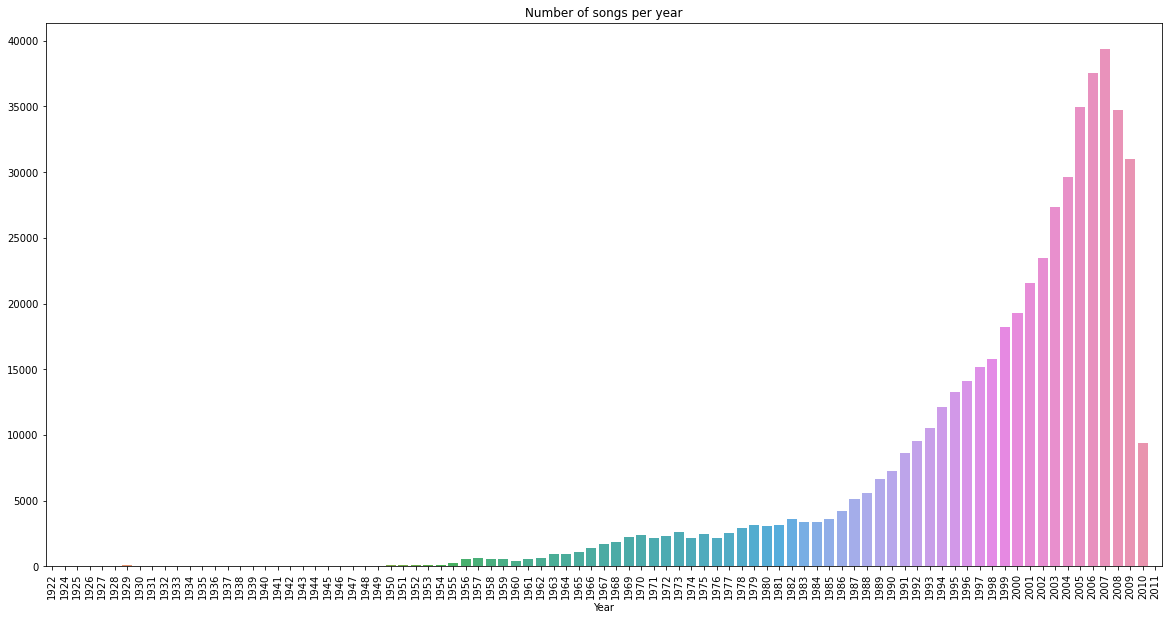

In [140]:
# Plotting the number of songs for each year 
fig, ax = plt.subplots(figsize=(20,10)) 
sns.countplot(data = df, x = "Year")
plt.xticks(rotation = 90)
plt.title("Number of songs per year")
plt.ylabel("")
plt.show()
fig.savefig("songs_year.png")

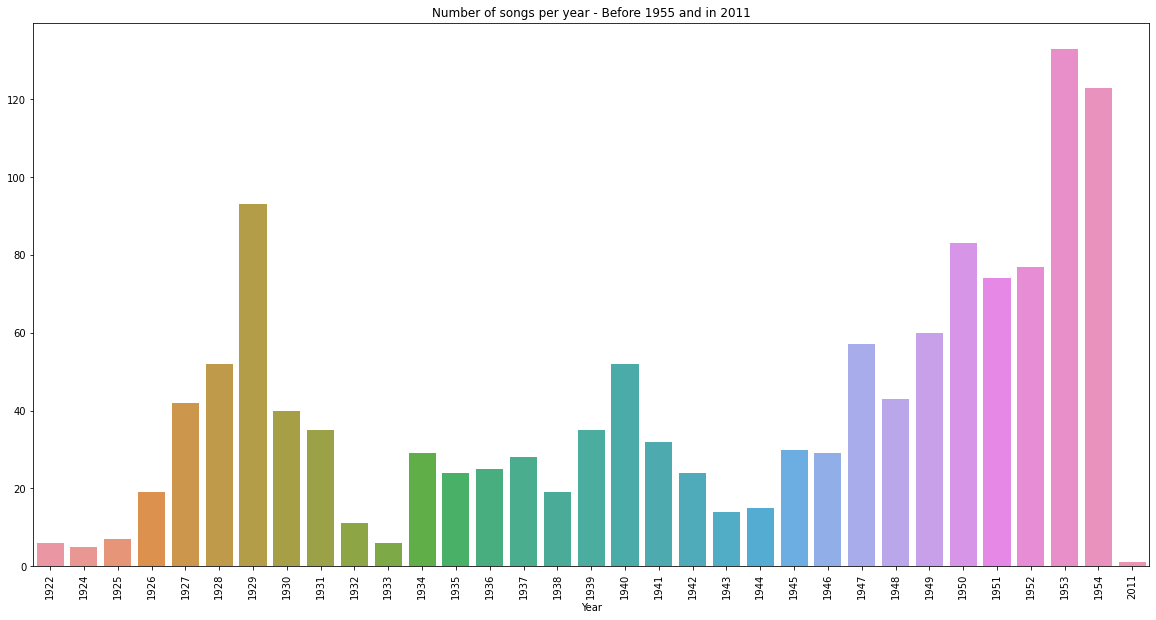

In [141]:
# Plotting the number of songs for under-represented years 
fig, ax = plt.subplots(figsize=(20,10)) 
sns.countplot(data = df[(df["Year"] < 1955) | (df["Year"] == 2011)], x = "Year")
plt.xticks(rotation = 90)
plt.title("Number of songs per year - Before 1955 and in 2011")
plt.ylabel("")
plt.show()
fig.savefig("songs_under_year.png")

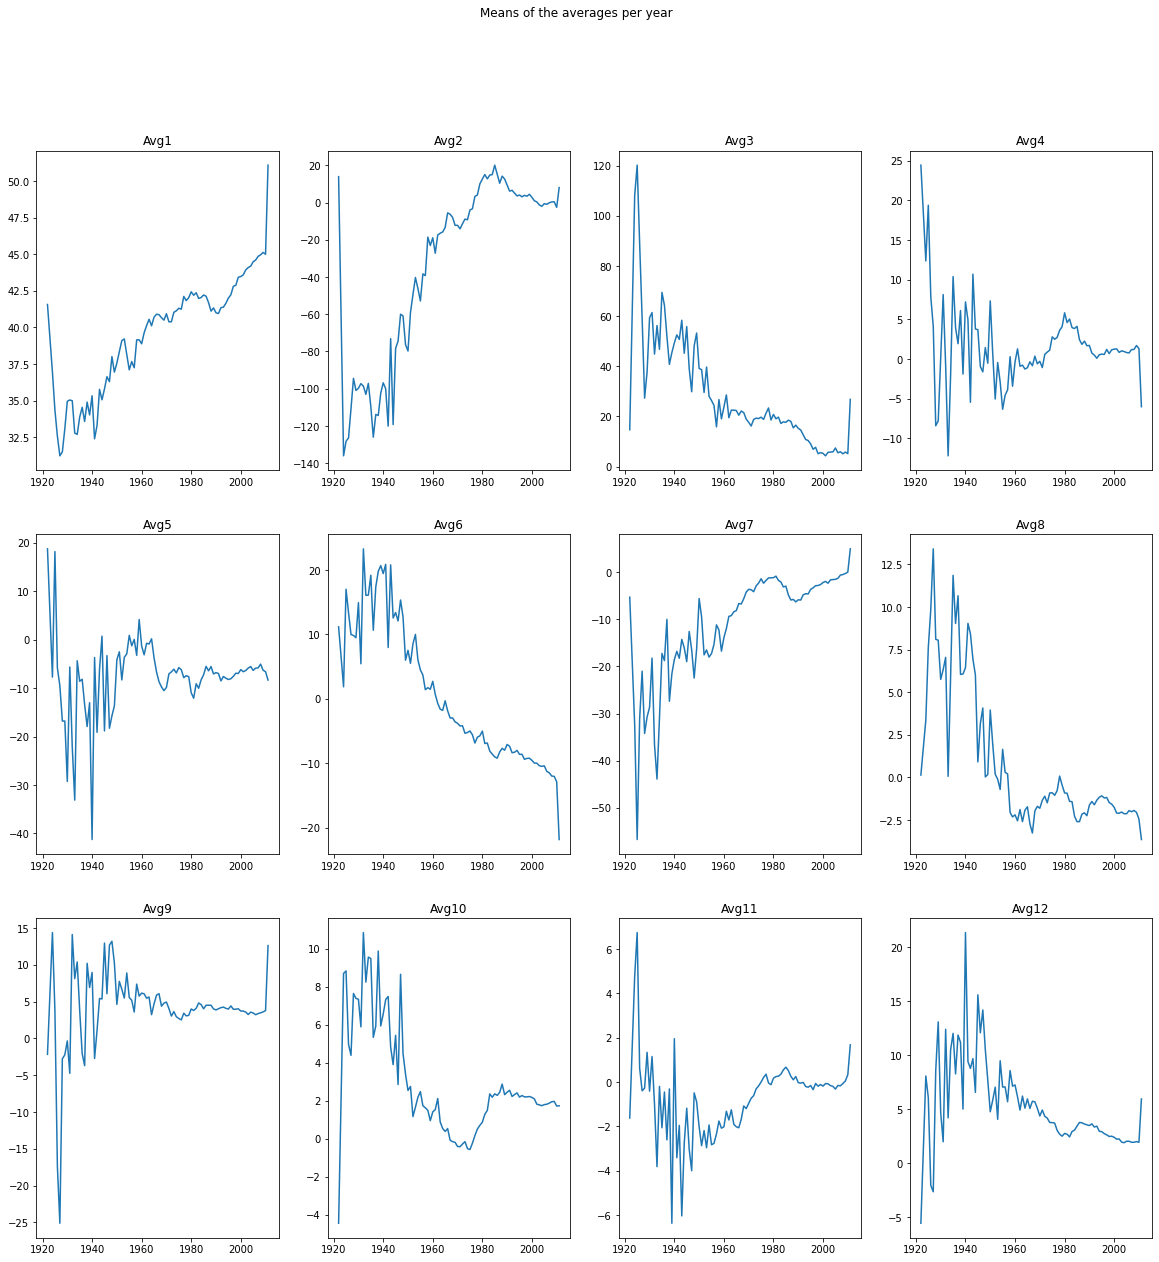

In [138]:
# Plotting the Avg variables (predictors) in function of the year

fig, axes = plt.subplots(3,4, figsize=(20,20))

fig.suptitle('Means of the averages per year')
n = 1
for i in range(3):
  for j in range(4):
    axes[i,j].plot(df.groupby("Year").mean()[f"Avg{n}"])
    axes[i,j].set_title(f"Avg{n}")
    n += 1

fig.savefig("avg_var.png")

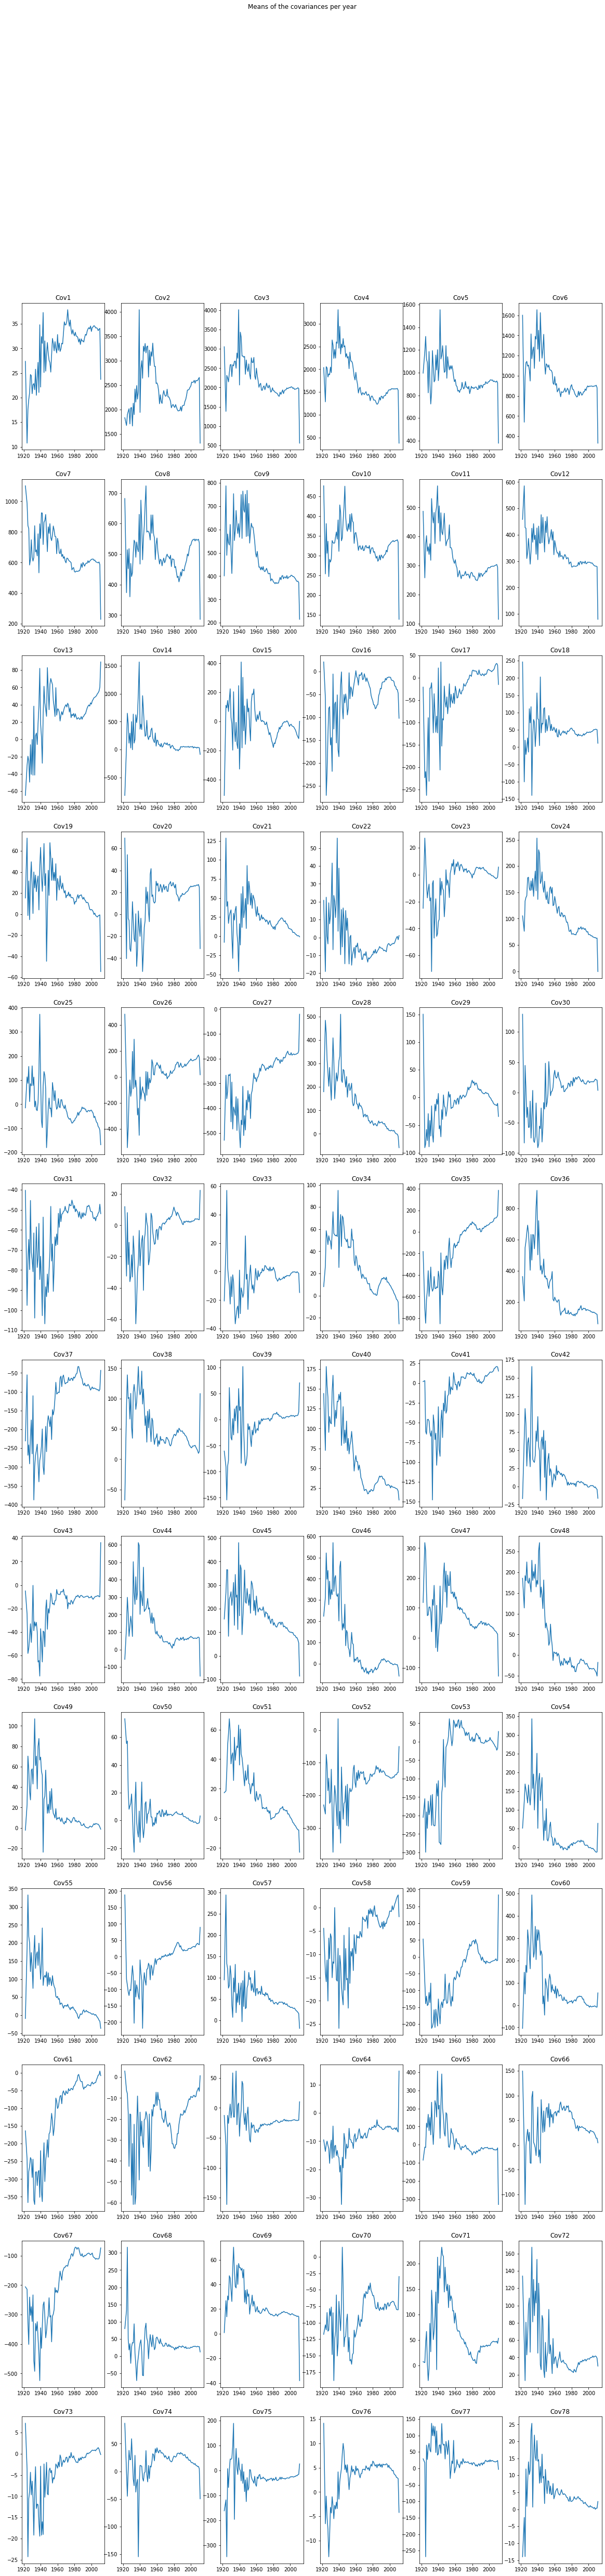

In [139]:
# Plotting the Cov variables (predictors) in function of the year

fig, axes = plt.subplots(13,6, figsize=(20,80))

fig.suptitle('Means of the covariances per year')
n = 1
for i in range(13):
  for j in range(6):
    axes[i,j].plot(df.groupby("Year").mean()[f"Cov{n}"])
    axes[i,j].set_title(f"Cov{n}")
    n += 1

fig.savefig("cov_var.png")

<a name="pca_proj">

### PCA Projections

In [142]:
# PCA need data to be scaled

x = df.drop(columns=["Year","Decade"])
x = StandardScaler().fit_transform(x)

> 2 Dimensions

In [143]:
# 2-dimensional PCA

pca2D = PCA(n_components=2)
principalComponents = pca2D.fit_transform(x)
df_pca = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
df_pca = pd.concat([df_pca,df[["Decade","Year"]]],axis=1)
df_pca.head()

,PC1,PC2,Decade,Year
0,-3.252860,-0.518683,2000,2001
1,-2.766634,0.973234,2000,2001
2,-3.013243,-1.536120,2000,2001
3,-3.316929,0.318614,2000,2001
4,-3.603851,-0.007998,2000,2001


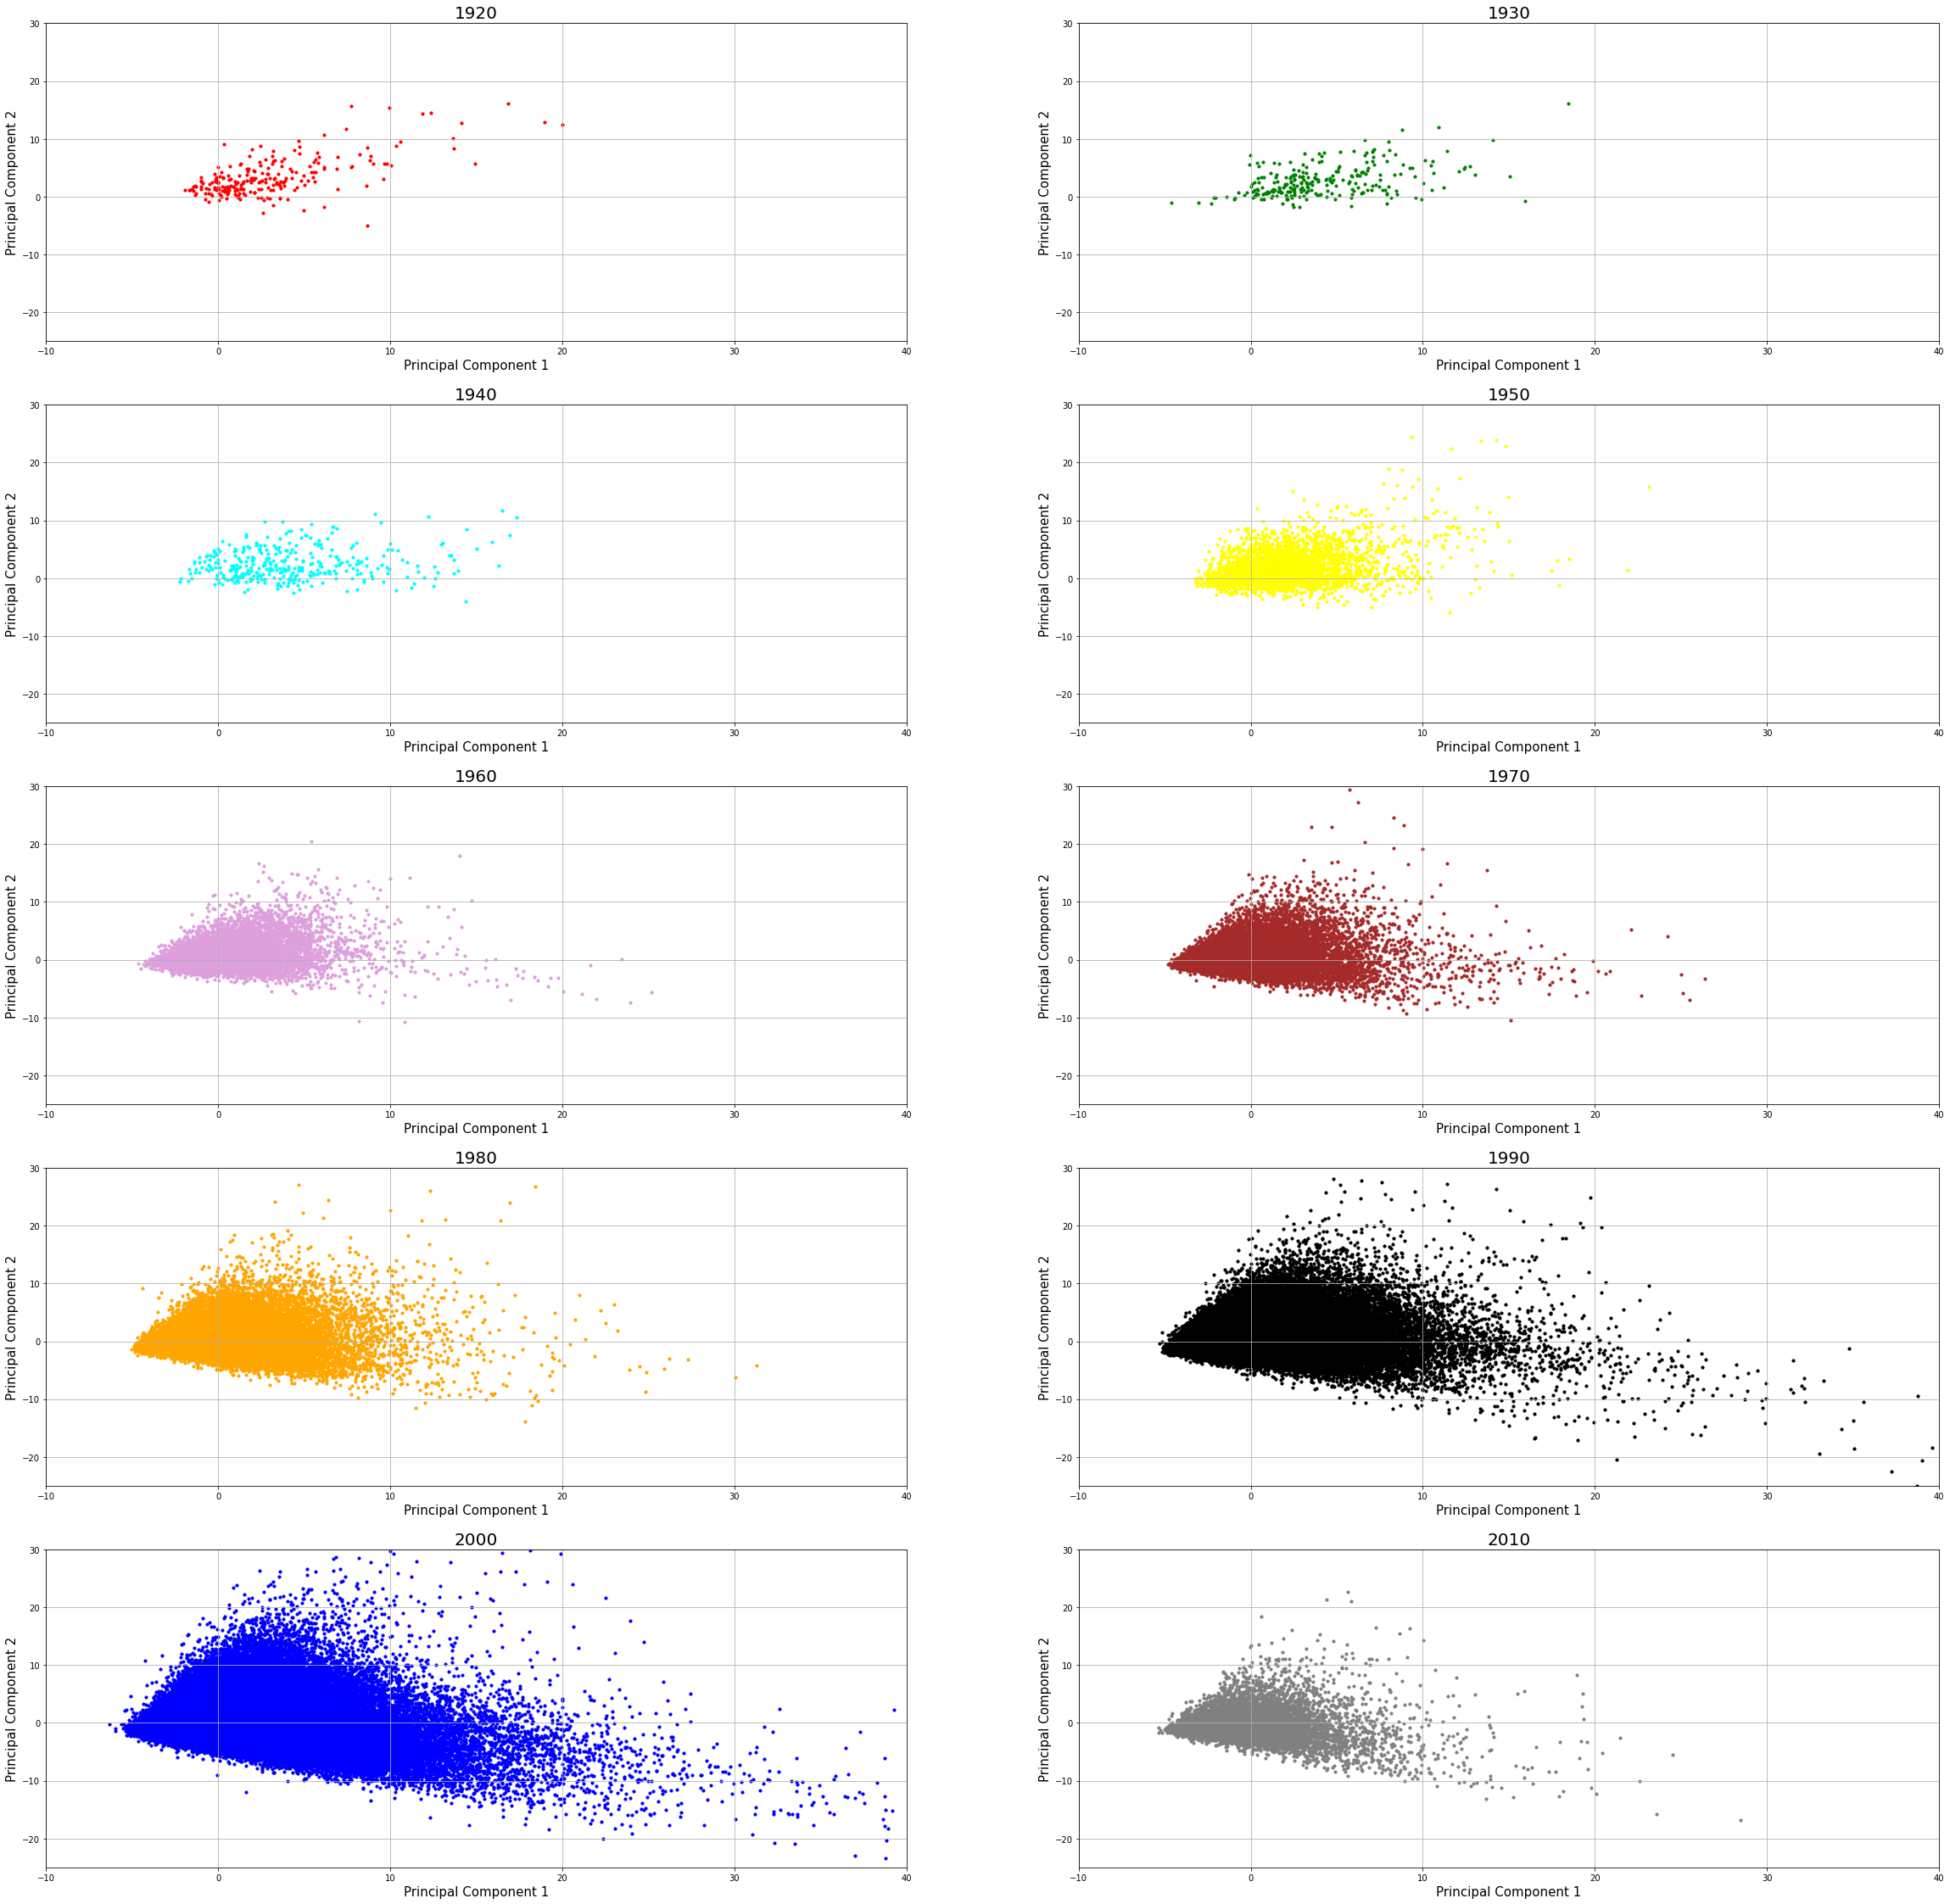

In [145]:
# Plotting 2D-PCA on many graphs in order to have a clearer view

d_c = {1920: 'red',1930: 'green',1940: 'cyan',1950: 'yellow',1960: 'plum',1970: 'brown',1980: 'orange',1990: 'black',2000: 'blue',2010: 'gray'}

fig = plt.figure(figsize = (40,40))

k=1
for v in sorted(df.Decade.unique()):
  ax = fig.add_subplot(5,2,k) 
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title(f"{v}", fontsize = 20)
  ax.set_xlim(-10,40)
  ax.set_ylim(-25,30)
  ax.scatter(df_pca[df_pca['Decade'] == v]['PC1']
            , df_pca[df_pca['Decade'] == v]['PC2']
            , c = d_c[v]
            , s = 10)
  ax.grid()
  k+=1

fig.savefig("pca2Dsolo.png")

> 3 Dimensions

In [146]:
# 3-dimensional PCA

pca3D = PCA(n_components=3)
principalComponents = pca3D.fit_transform(x)
df_pca = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])
df_pca = pd.concat([df_pca,df[["Decade", "Year"]]],axis=1)
df_pca.head()

,PC1,PC2,PC3,Decade,Year
0,-3.252861,-0.518692,0.853026,2000,2001
1,-2.766634,0.973224,-0.128409,2000,2001
2,-3.013244,-1.536149,0.611679,2000,2001
3,-3.316931,0.318610,-1.138229,2000,2001
4,-3.603850,-0.007989,0.126230,2000,2001


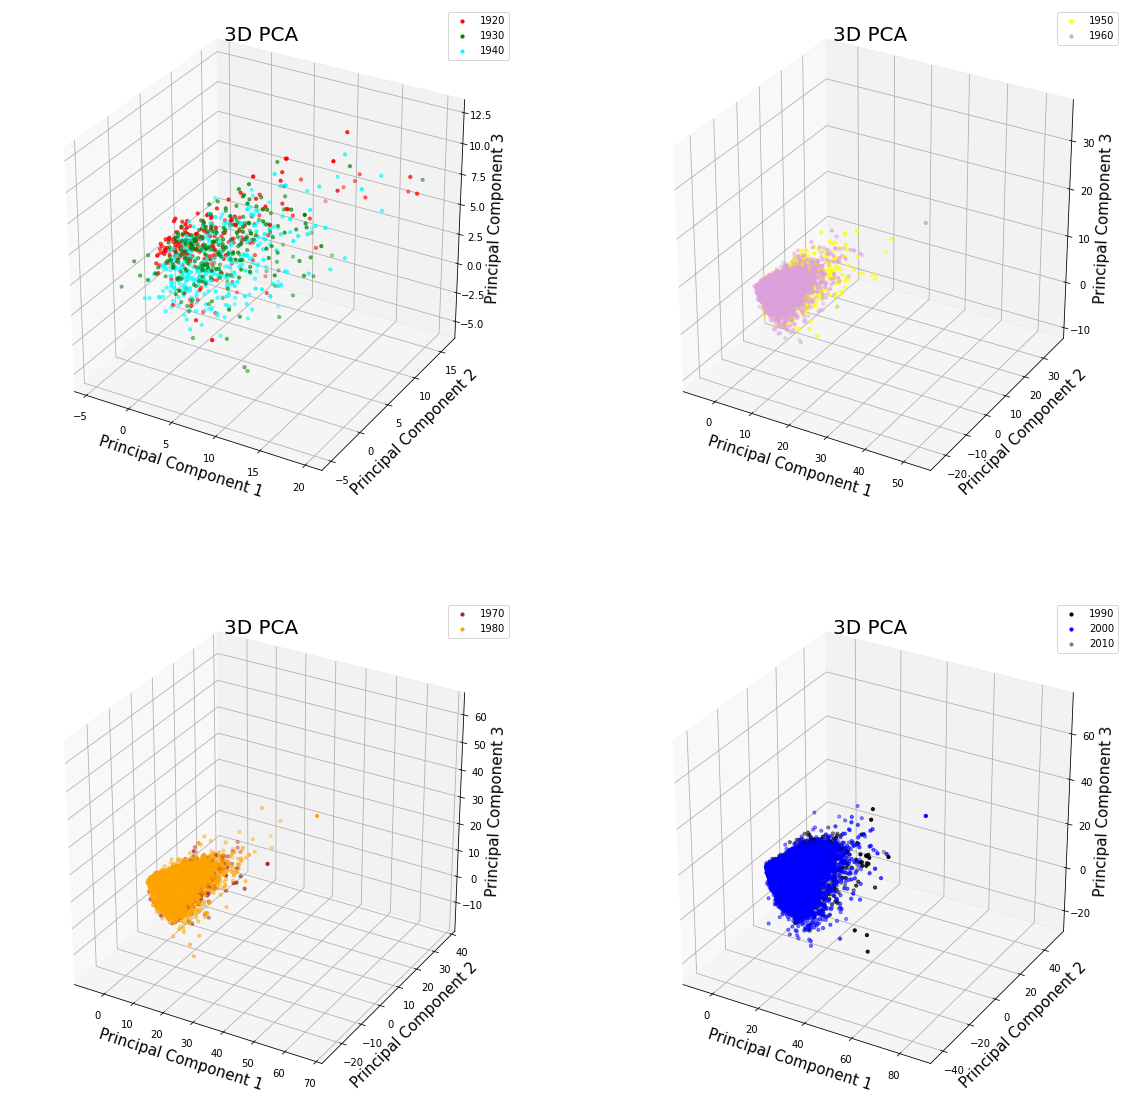

In [147]:
# Plotting 3D-PCA on many graphs in order to have a clearer view

d = {1:[1920,1930,1940],2:[1950,1960],3:[1970,1980],4:[1990,2000,2010]}
d_c = {1920: 'red',1930: 'green',1940: 'cyan',1950: 'yellow',1960: 'plum',1970: 'brown',1980: 'orange',1990: 'black',2000: 'blue',2010: 'gray'}

fig = plt.figure(figsize = (20,20))

for k,v in d.items():
  ax = fig.add_subplot(2,2,k,projection ='3d') 
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_zlabel('Principal Component 3', fontsize = 15)

  ax.set_title('3D PCA', fontsize = 20)
  for target in v:
      ax.scatter(df_pca[df_pca['Decade'] == target]['PC1']
                , df_pca[df_pca['Decade'] == target]['PC2']
                , df_pca[df_pca['Decade'] == target]['PC3']
                , c = d_c[target]
                , s = 10)
  ax.legend(v)
  ax.grid()

fig.savefig("pca3Dcombo.png")

<a name="process_data">

## *Data Processing*
---

<a name="umbalanced">

### Dealing with imbalanced data

> Dummy Classifier

In [18]:
# Modeling a Dummy Classifier which always predict the same decade : the most frequent in the dataset (Here, the 2000s)

target = df["Decade"].to_numpy()
data = df.drop(columns=["Decade","Year"])

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(data, target)
target_pred = dummy.predict(data)

In [19]:
print(f"The accuracy of the dummy model is {accuracy_score(target, target_pred):.3f} while the model always predicts Decade as {target_pred[0]}."
      f"\n\nAs there are {len(Counter(df.Decade))} different decades, from {min(sorted(Counter(df.Decade)))} to {max(sorted(Counter(df.Decade)))}, the accuracy should not be so high.")

The accuracy of the dummy model is 0.580 while the model always predicts Decade as 2000.

As there are 10 different decades, from 1920 to 2010, the accuracy should not be so high.


> We have to find a way to face imbalanced data.

> I introduce a count treshold for each year below which the data will not be taken into account. 
>> If there is not enough examples/instances for a specified year, this year will be considered as useless.

> Regarding my previous plots, I chose this threshold to be 100. 
>> This method deletes all songs from 1922 to 1952 as well as 2011.





In [20]:
threshold = 100
useless_years = [year for year in df["Year"].unique() if df[ df["Year"] == year].shape[0] < threshold]
np.array(sorted(useless_years))

array([1922, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933,
       1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944,
       1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 2011])

<a name="split">

### Splitting Dataset



> To split our dataset, a rule is given by its creator :

*   Train set : first 463,715 examples
*   Test set : last 51,630 examples

> It allows to avoid the 'producer effect' by making sure no song
from a given artist ends up in both the train and test set.

> As I decided to delete examples whose year is "useless", I will first split the dataset with respect to the previous rule and then I will delete them.




In [21]:
train = df.head(463715)
train2 = train.query("Year not in @useless_years")
x_train = train2.drop(columns=["Year","Decade"])
y_train = train2["Year"]
print(f"There are {train2.shape[0]} rows ({train.shape[0]-train2.shape[0]} were deleted)")

There are 462791 rows (924 were deleted)


In [22]:
test = df.tail(51630).reset_index(drop=True)
test2 = test.query("Year not in @useless_years")
x_test = test2.drop(columns=["Year","Decade"])
y_test = test2["Year"]
print(f"There are {test2.shape[0]} rows ({test.shape[0]-test2.shape[0]} were deleted)")

There are 51487 rows (143 were deleted)


<a name="scale">

### Scaling

In [23]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train),columns=[c for c in df.columns if c not in ["Year","Decade"]])
x_test = pd.DataFrame(scaler.transform(x_test),columns=[c for c in df.columns if c not in ["Year","Decade"]])

<a name="dim_red">

### Dimensionality reduction using PCA

> There are 90 predictors in our dataset. 
>> In order to speed up machine learning algorithms, it is important to reduce this number, while keeping maximum of information in order to keep our model performant.

In [24]:
for i in np.arange(.75,1,.05):
  pca = PCA(i).fit(x_train)
  print(f"To keep {round(i*100)}% of the variance, we need {pca.n_components_} principal components")

To keep 75% of the variance, we need 33 principal components
To keep 80% of the variance, we need 39 principal components
To keep 85% of the variance, we need 46 principal components
To keep 90% of the variance, we need 55 principal components
To keep 95% of the variance, we need 67 principal components


> I chose to use 55 components.

In [25]:
pca = PCA(n_components=55).fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

In [26]:
# Using pickle library, i save my pca model in a .pkl file in order to use it later in my API

pickle_out = open("pca.pkl", mode = "wb") 
pickle.dump(pca, pickle_out) 
pickle_out.close()

<a name="modeling">

## *Modeling*
---

<a name="func">

###Metrics

Scoring

In [51]:
# Returned score is the accuracy (in percent) : 100 * (number of correct year predictions) / (number of year predictions) 
# The higher the better

def accuracy(predictions):
  results = pd.DataFrame(data={"reality":y_test,"predicted":predictions})
  results["correct"] = results["reality"] == results["predicted"]
  score = round(results['correct'].value_counts()[1] / results.shape[0] * 100,3)
  print('-------------------------------------\n\t\tExact\n\t\t_____\n\nScore : ',score,'%\n')
  return score

In [52]:
# Print the accuracy for the decade (in percent) : 100 * (number of correct decade predictions) / (number of decade predictions)
# Obviously, decade is easier to predict than the exact year

def accuracy_decade(predictions):
  results = pd.DataFrame(data={"reality":y_test,"predicted":predictions})
  results["correct"] = (results["predicted"] - results["predicted"]%10) == (results["reality"] - results["reality"]%10)
  score = round(results['correct'].value_counts()[1] / results.shape[0] * 100,3)
  print('-------------------------------------\n\t\tDecade\n\t\t______\n\nScore : ',score,'%\n')

In [75]:
# Print the average absolute difference between Year predictions and reality
# The lower the better

def average_difference(predictions):
  results = pd.DataFrame(data={"reality":y_test,"predicted":predictions})
  results["diff"] = results.apply(lambda x: abs(x["predicted"] - x["reality"]), axis=1)
  avg_abs_diff = round(results["diff"].sum() / results.shape[0],3)
  print('-------------------------------------\nAverage absolute difference (years)\n\t_____________________\n\n','Score : ',avg_abs_diff,'\n')
  return avg_abs_diff

In [54]:
# Returned table is a DataFrame containing, for each year : (number of songs for real) - (number of songs predicted)
# It acs like a confusion matrix : it allows to see how many songs belongs to each class according to the model
# For example, it could allow to show that a model is a kind of Dummy Classifier

def correctness_per_year(predictions):
  years = sorted(y_train.unique())
  s = pd.DataFrame(data = np.zeros(shape=(1,len(years))), columns=years)

  for y in years:
    nb_pred = 0
    nb_real = 0
    for p in predictions:
      if p == y:
          nb_pred +=1
    for real in y_test:
      if real == y:
        nb_real +=1
    s[y] = nb_real - nb_pred
  display(HTML("<h4>Confusion : value = nb_real - nb_predicted</h4>"))
  display(HTML("<h5>value > 0 : under-predicted</h5>"))
  display(HTML("<h5>value < 0 : over-predicted</h5>"))
  display(s)
  return s

In [76]:
def all_checkings(predictions):
  acc = accuracy(predictions)
  accuracy_decade(predictions)
  avg_abs_diff = average_difference(predictions)
  df = correctness_per_year(predictions)
  return acc, df, avg_abs_diff

<a name="models">

###Models

> I am going to try several algorithms to get the best results, regarding the different metrics I introduced you before.
>> Most of them are Classification algorithms, because we are facing a classification problem.
>>> However, I also tried to perform a Linear Regression, by seeing this problem as a regression one (predicting years and then rounding the float values to integers).

In [31]:
# Dictionnary containing the accuracy, the "confusion matrix" and the average year distance of each model
# Used to compare these models at the end
# 'model_name' : [accuracy, confusion_matrix, avg_abs_diff_year]

df_compare = dict()

####Classification

##### KNN

> Grid Search to find the best combination of hyper-parameters

In [100]:
'''
param_grid = {'n_neighbors':[1,2,3,5,10],'weights':['uniform','distance']}
grid = GridSearchCV(KNeighborsClassifier(),param_grid)
grid.fit(x_train_pca,y_train)

print(f'Best score : {grid.best_score_}\nBest param : {grid.best_params_}\n')
'''

"\nparam_grid = {'n_neighbors':[1,2,3,5,10],'weights':['uniform','distance']}\ngrid = GridSearchCV(KNeighborsClassifier(),param_grid)\ngrid.fit(x_train_pca,y_train)\n\nprint(f'Best score : {grid.best_score_}\nBest param : {grid.best_params_}\n')\n"

> I decided to perform a hyper-parameters optimization manually, because the Grid Search scores were not significant enough to compare the different models.
>> As you can see in the functions part, nb_per_year() is a function that I use to create a kind of multi-class confusion matrix : it tells me how good is the model for predicting each year, by computing 
`(nb_real - nb_predicted)` for each year.

In [101]:
dfs_KNN = dict()
for k in [1,2,3,4,10]:
  for w in ['uniform','distance']:
    if (w == 'distance' and (k == 1 or k == 2)): # k=1 & w='distance' <=> k=2 & w='distance' <=> k=1 & w='uniform'
      break

    key = f"KNN_{k}_{w}"
    print('\n\n',key)
    model = KNeighborsClassifier(n_neighbors=k, weights=w)
    model.fit(x_train_pca,y_train)
    preds = model.predict(x_test_pca)
    accKNN, dfKNN, avg_abs_diffKNN = all_checkings(preds)
    dfs_KNN[key] = [accKNN, dfKNN, avg_abs_diffKNN]



 KNN_1_uniform
-------------------------------------
		Exact
		_____

Score :  5.592 %

-------------------------------------
		Decade
		______

Score :  47.394 %

-------------------------------------
Average absolute difference (years)
	_____________________

 Score :  9.07 



,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,1,-3,-11,-25,-6,19,8,0,2,-21,-33,20,22,63,64,41,-2,1,49,-29,5,-45,-100,-48,-19,30,-57,39,105,13,-16,-37,10,22,-11,-75,-62,-96,-48,-117,-196,23,106,-10,14,-64,2,-26,68,-192,51,-78,64,112,156,23,209,85




 KNN_2_uniform
-------------------------------------
		Exact
		_____

Score :  4.588 %

-------------------------------------
		Decade
		______

Score :  40.88 %

-------------------------------------
Average absolute difference (years)
	_____________________

 Score :  10.164 



,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,-8,-17,-31,-54,-40,-18,-30,-28,-40,-58,-74,-39,-75,-42,-53,-80,-183,-159,-126,-237,-246,-223,-332,-199,-226,-234,-267,-166,-104,-226,-221,-248,-251,-252,-371,-380,-483,-473,-516,-587,-672,-451,-398,-484,-423,-396,-485,-351,-127,-283,200,415,994,1440,2197,2529,2692,1000




 KNN_3_uniform
-------------------------------------
		Exact
		_____

Score :  4.096 %

-------------------------------------
		Decade
		______

Score :  36.633 %

-------------------------------------
Average absolute difference (years)
	_____________________

 Score :  11.216 



,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,-19,-21,-54,-93,-66,-51,-63,-50,-67,-74,-115,-84,-144,-89,-159,-177,-299,-310,-271,-370,-406,-351,-491,-323,-372,-390,-370,-273,-218,-338,-338,-375,-391,-399,-537,-499,-636,-638,-663,-709,-764,-567,-437,-433,-401,-297,-251,-34,177,157,729,1097,1686,2123,2660,2525,2387,936




 KNN_3_distance
-------------------------------------
		Exact
		_____

Score :  5.658 %

-------------------------------------
		Decade
		______

Score :  47.723 %

-------------------------------------
Average absolute difference (years)
	_____________________

 Score :  9.021 



,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,1,-2,-7,-24,-5,17,6,-1,4,-17,-30,20,21,63,66,46,6,6,45,-23,0,-38,-100,-39,-15,30,-46,42,113,7,-10,-21,23,48,-2,-61,-58,-62,-24,-93,-183,33,128,-22,31,-23,10,28,85,-174,50,-100,35,12,3,-66,139,128




 KNN_4_uniform
-------------------------------------
		Exact
		_____

Score :  4.18 %

-------------------------------------
		Decade
		______

Score :  36.137 %

-------------------------------------
Average absolute difference (years)
	_____________________

 Score :  11.699 



,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,-27,-23,-71,-110,-85,-60,-72,-67,-92,-86,-153,-115,-173,-137,-204,-213,-387,-403,-370,-436,-515,-424,-574,-362,-438,-463,-420,-306,-259,-368,-371,-383,-424,-404,-560,-517,-585,-614,-636,-638,-687,-423,-238,-281,-145,-33,72,324,561,476,1158,1359,1712,1877,2106,1909,1924,874




 KNN_4_distance
-------------------------------------
		Exact
		_____

Score :  5.834 %

-------------------------------------
		Decade
		______

Score :  48.498 %

-------------------------------------
Average absolute difference (years)
	_____________________

 Score :  8.913 



,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,-1,-1,-6,-20,-6,26,6,-2,2,-18,-29,19,28,61,71,57,15,11,48,-7,-4,-23,-91,-20,2,36,-36,55,122,24,4,-11,25,56,-5,-33,-46,-52,-8,-100,-163,53,157,12,85,-13,43,38,138,-156,91,-86,-101,-116,-154,-240,80,183




 KNN_10_uniform
-------------------------------------
		Exact
		_____

Score :  5.782 %

-------------------------------------
		Decade
		______

Score :  48.542 %

-------------------------------------
Average absolute difference (years)
	_____________________

 Score :  9.316 



,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,-25,-6,-40,-43,-60,-24,-39,-45,-50,-48,-106,-31,-55,-20,-56,-65,-105,-164,-99,-104,-224,-134,-207,-93,-89,-38,-68,27,111,-51,-17,30,21,37,-49,-62,-55,-72,-22,-117,-169,60,170,106,150,139,87,106,77,-271,-82,-308,-316,-214,82,653,1149,838




 KNN_10_distance
-------------------------------------
		Exact
		_____

Score :  6.495 %

-------------------------------------
		Decade
		______

Score :  52.86 %

-------------------------------------
Average absolute difference (years)
	_____________________

 Score :  8.29 



,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,-1,10,0,4,13,38,10,2,6,-3,-14,43,53,98,97,105,82,56,110,67,45,35,-20,24,57,102,50,143,210,107,89,132,124,160,119,83,102,74,84,24,-25,180,374,223,281,215,215,197,234,-124,3,-444,-833,-1106,-1325,-889,-246,550


In [102]:
# As it took time to run all these models, I chose to save my dictionnary in a .pkl file

pic1 = open("dfs_KNN.pkl",mode='wb')
pickle.dump(dfs_KNN,pic1)
pic1.close()

> Now that I have fitted all my K-NN models and save the prediction results of each in a dictionnary, let's compare them.
>> With the accuracy metric, K-NN_10_distance is the best. However, accuracy is not relevant enough to compare our models, as we saw with Dummy Classifier. Indeed, we are facing umbalanced data so the predictions may not be good as we think.

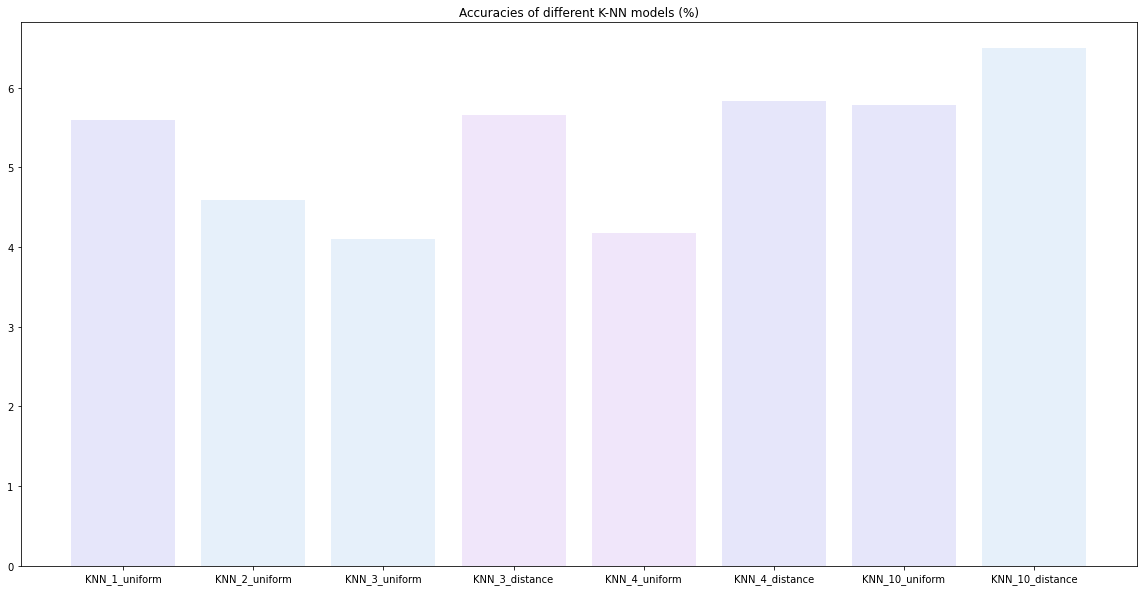

In [150]:
fig, ax = plt.subplots(figsize=(20,10)) 
plt.bar(dfs_KNN.keys(),[dfs_KNN[k][0] for k in dfs_KNN.keys()], color=['#e6e6fa','#e6f0fa','#e6f0fa','#f0e6fa','#f0e6fa','#e6e6fa','#e6e6fa','#e6f0fa','#e6f0fa'])
plt.title("Accuracies of different K-NN models (%)")
plt.show()

#fig.savefig("accuracies_KNN.png")

> Average difference between the number of predictions and the number of real year label for each year is the most pertinent metric, computed from the DataFrame returned by `correctness_per_year() `function.
>> How it works :
* For `year = 1970`, 500 songs (`nb_predicted = 500`) were predicted, while in reality, only 375 songs (`nb_real = 375`) were expected in the test set.
* implies `diff_nb = nb_real - nb_predicted = -125`
* We can say that 1970 is over-predicted
* Then we do the average of diff_nb for all years and we compare each model
>>> The lower the better
>>>> We can see that the best model must have the `weights='distance'` parameter because it reduces a lot the computed average. Moreover, KNN_3_distance seems to be the best, comparing to the others.

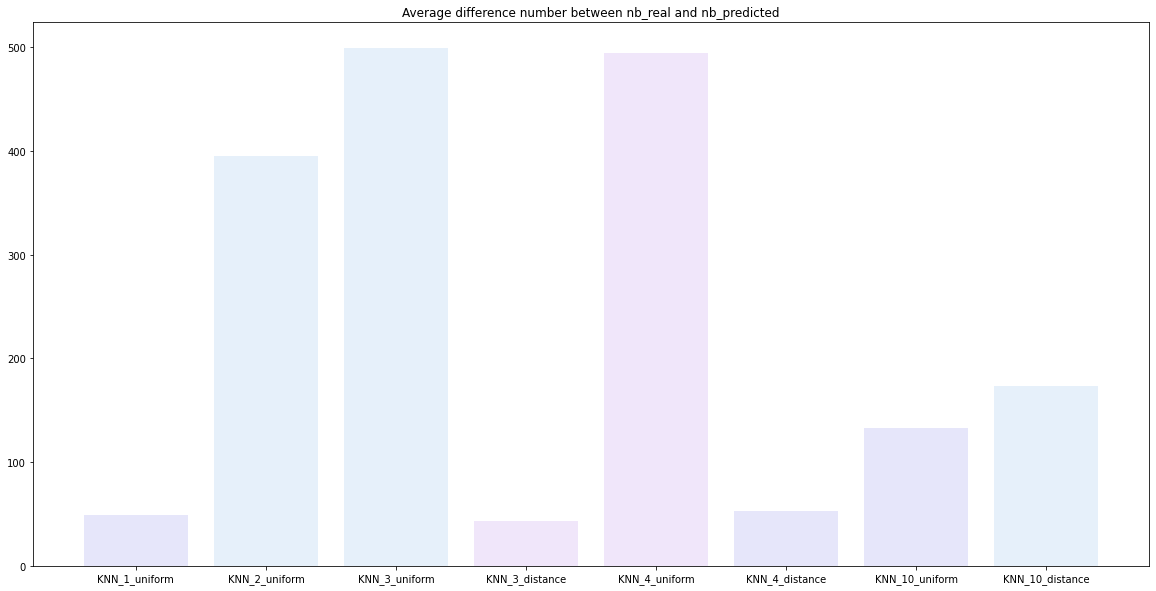

In [151]:
fig, ax = plt.subplots(figsize=(20,10)) 
plt.bar(dfs_KNN.keys(),[np.mean([abs(el) for el in dfs_KNN[k][1].values[0]]) for k in dfs_KNN.keys()], color=['#e6e6fa','#e6f0fa','#e6f0fa','#f0e6fa','#f0e6fa','#e6e6fa','#e6e6fa','#e6f0fa','#e6f0fa'])
plt.title("Average difference number between nb_real and nb_predicted")
plt.show()

#fig.savefig("avg_difference_nb_KNN.png")

> To ensure we are not making a mistake because of an average value, let's look at the `diff_nb` value of every year for each model?
>> Reminder : `diff_nb = nb_real - nb-predicted`
>>> We can clearly see that KNN_1, KNN_3_dist and KNN_4_dist are the model with the less variance, which is good. Also, KNN_3_dist seems to be the best, as we said before.

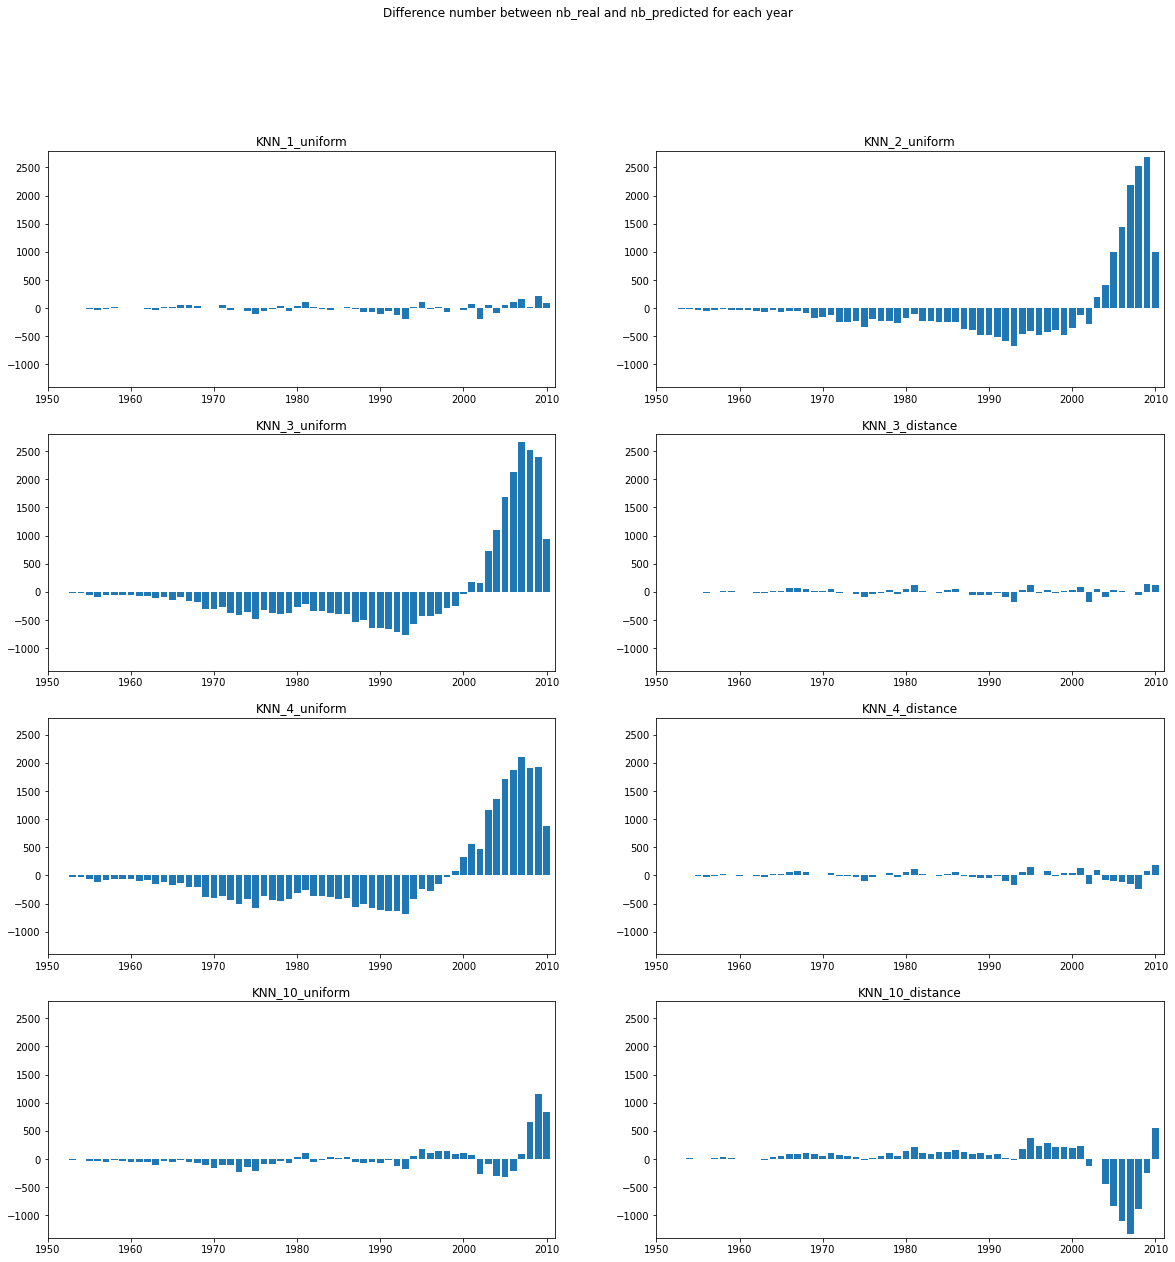

In [152]:
fig, axes = plt.subplots(4,2, figsize=(20,20))
i=0
j=0
fig.suptitle("Difference number between nb_real and nb_predicted for each year")
for k in dfs_KNN.keys():
  if j!=0 and j%2==0:
    j=0
    i+=1
  axes[i,j].bar(x=dfs_KNN[k][1].columns, height=dfs_KNN[k][1].values[0])
  axes[i,j].set_title(f"{k}")
  axes[i,j].set_xlim(1950,2011)
  axes[i,j].set_ylim(-1400,2800)
  j+=1

#fig.savefig("difference_nb_KNN.png")

> Thanks to these plots, we can conclude that `k = 3` and `weights = 'distance'` is the best optimization of K-NN's hyperparameters, for this dataset.

In [33]:
modelKNN3dist = KNeighborsClassifier(n_neighbors=3, weights='distance')
modelKNN3dist.fit(x_train_pca,y_train)
predsKNN3dist = modelKNN3dist.predict(x_test_pca)

In [77]:
# We add this model to our dictionnary that we'll use to compare different Machine Learning algorithms.

accKNN3dist, dfKNN3dist, avg_abs_diffKNN3dist = all_checkings(predsKNN3dist)
df_compare['modelKNN3dist'] = [accKNN3dist, dfKNN3dist, avg_abs_diffKNN3dist]

-------------------------------------
		Exact
		_____

Score :  5.658 %

-------------------------------------
		Decade
		______

Score :  47.723 %

-------------------------------------
Average absolute difference (years)
	_____________________

 Score :  9.021 



,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,1,-2,-7,-24,-5,17,6,-1,4,-17,-30,20,21,63,66,46,6,6,45,-23,0,-38,-100,-39,-15,30,-46,42,113,7,-10,-21,23,48,-2,-61,-58,-62,-24,-93,-183,33,128,-22,31,-23,10,28,85,-174,50,-100,35,12,3,-66,139,128


##### Logistic Regression

> I had to increase the value of max_iterations parameter, because the default one (100) was not enough to get the model to converge.

In [37]:
modelLogReg = LogisticRegression(max_iter=500)
modelLogReg.fit(x_train_pca,y_train)
predsLogReg = modelLogReg.predict(x_test_pca)

In [79]:
accLogReg, dfLogReg, avg_abs_diffLogReg = all_checkings(predsLogReg)
df_compare['LogReg'] = [accLogReg, dfLogReg, avg_abs_diffLogReg]

-------------------------------------
		Exact
		_____

Score :  7.507 %

-------------------------------------
		Decade
		______

Score :  57.964 %

-------------------------------------
Average absolute difference (years)
	_____________________

 Score :  8.226 



,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,6,15,15,-12,23,46,30,26,45,23,23,66,94,151,162,200,181,163,249,198,254,187,116,215,240,259,188,189,342,199,271,269,258,361,469,395,292,534,298,642,570,503,1166,726,1371,1392,1336,1881,1755,1991,2519,2212,-4629,-4409,-19882,950,1833,1033


##### Linear Discriminant Analysis

> In our situation, LDA model is very fast to fit and predict. 
>> That's why I chose to fit it using x_train and then x_train_pca in order to see if the results might change while keeping the maximum information.

In [124]:
dfs_LDA = dict()

modelLDA_pca = LinearDiscriminantAnalysis()
modelLDA_pca.fit(x_train_pca,y_train)
predsLDA_pca = modelLDA_pca.predict(x_test_pca)
accLDA_pca, dfLDA_pca, _ = all_checkings(predsLDA_pca)
dfs_LDA['LDA_pca'] = accLDA_pca, dfLDA_pca

modelLDA_npca = LinearDiscriminantAnalysis()
modelLDA_npca.fit(x_train,y_train)
predsLDA_npca = modelLDA_npca.predict(x_test)
accLDA_npca, dfLDA_npca, _ = all_checkings(predsLDA_npca)
dfs_LDA['LDA_no_pca'] = accLDA_npca, dfLDA_npca

-------------------------------------
		Exact
		_____

Score :  7.579 %

-------------------------------------
		Decade
		______

Score :  56.548 %

-------------------------------------
Average absolute difference (years)
	_____________________

 Score :  9.189 



,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,-178,-96,-334,-218,-257,-66,-105,6,8,19,28,34,83,143,185,195,193,199,257,184,257,188,117,216,243,278,199,190,360,234,258,277,235,433,504,403,583,597,554,809,827,763,1266,866,1394,1412,1280,1899,1787,2048,2601,2223,-4984,-5102,-18761,1143,1090,1033


-------------------------------------
		Exact
		_____

Score :  8.105 %

-------------------------------------
		Decade
		______

Score :  59.656 %

-------------------------------------
Average absolute difference (years)
	_____________________

 Score :  8.081 



,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,-184,-117,-329,-197,-278,-71,-88,-32,5,16,6,45,67,134,149,193,167,163,253,183,247,191,9,213,234,144,71,95,304,147,176,238,110,386,488,154,134,332,-119,-193,288,186,686,843,1249,1313,1030,1680,1584,1802,2374,1945,-3448,-4477,-13718,1351,841,1025


> Now, when we compare them with the same plots as with K-NN, we can see that without PCA, our LDA model has a better accuracy and a lower average value.

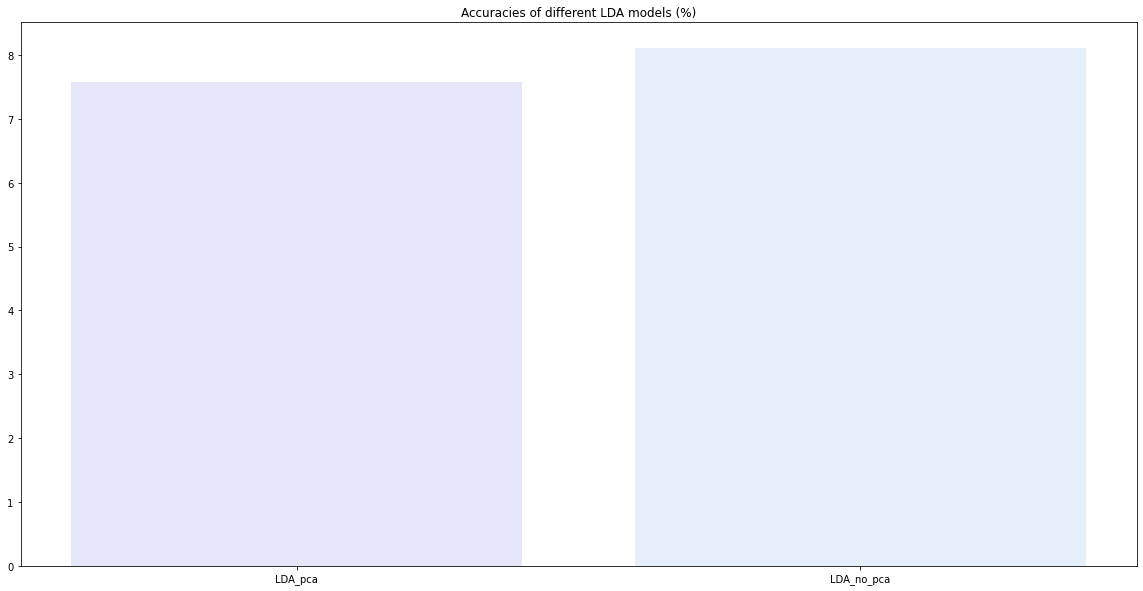

In [126]:
fig, ax = plt.subplots(figsize=(20,10)) 
plt.bar(dfs_LDA.keys(),[dfs_LDA[k][0] for k in dfs_LDA.keys()], color=['#e6e6fa','#e6f0fa'])
plt.title("Accuracies of different LDA models (%)")
plt.show()

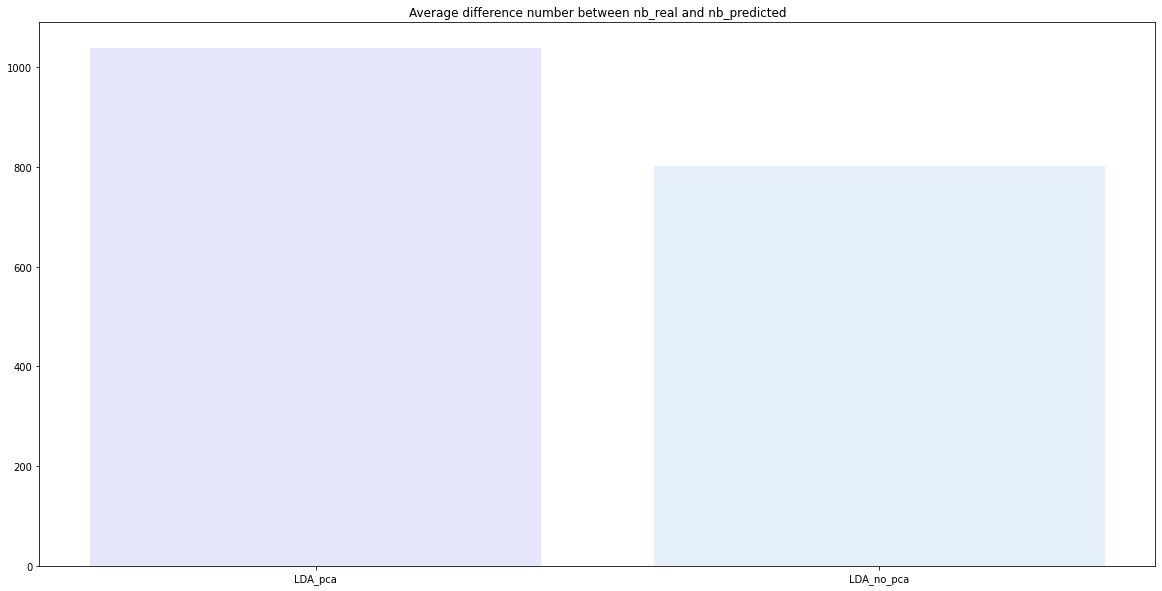

In [127]:
fig, ax = plt.subplots(figsize=(20,10)) 
plt.bar(dfs_LDA.keys(),[np.mean([abs(el) for el in dfs_LDA[k][1].values[0]]) for k in dfs_LDA.keys()], color=['#e6e6fa','#e6f0fa'])
plt.title("Average difference number between nb_real and nb_predicted")
plt.show()

> So let's keep the LDA with no PCA for our ML algorithms comparison.

In [130]:
modelLDA = LinearDiscriminantAnalysis()
modelLDA.fit(x_train,y_train)
predsLDA = modelLDA.predict(x_test)
accLDA, dfLDA, avg_abs_diffLDA = all_checkings(predsLDA)
df_compare['LDA'] = accLDA, dfLDA, avg_abs_diffLDA

-------------------------------------
		Exact
		_____

Score :  8.105 %

-------------------------------------
		Decade
		______

Score :  59.656 %

-------------------------------------
Average absolute difference (years)
	_____________________

 Score :  8.081 



,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,-184,-117,-329,-197,-278,-71,-88,-32,5,16,6,45,67,134,149,193,167,163,253,183,247,191,9,213,234,144,71,95,304,147,176,238,110,386,488,154,134,332,-119,-193,288,186,686,843,1249,1313,1030,1680,1584,1802,2374,1945,-3448,-4477,-13718,1351,841,1025


##### Quadratic Discriminant Analysis

> In the same way as before with LDA, I tried to fit QDA model using x_train (and not x_train_pca) in order to keep the maximum information and get better result.
>> But it was the opposite : I got the best results with x_train_pca.

In [119]:
modelQDA = QuadraticDiscriminantAnalysis()
modelQDA.fit(x_train_pca,y_train)
predsQDA = modelQDA.predict(x_test_pca)
accQDA, dfQDA, avg_abs_diffQDA = all_checkings(predsQDA)
df_compare['QDA'] = accQDA, dfQDA, avg_abs_diffQDA

-------------------------------------
		Exact
		_____

Score :  3.768 %

-------------------------------------
		Decade
		______

Score :  28.149 %

-------------------------------------
Average absolute difference (years)
	_____________________

 Score :  16.096 



,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,3,-9,-143,-421,-312,-112,-134,-86,-116,-131,-1021,-783,-259,-428,-718,-35,27,-182,-245,-78,-267,-513,-1045,-772,-9687,-2019,-215,-1247,-114,29,-197,-1001,-1551,159,-388,185,-1106,391,501,434,638,967,1066,992,1170,806,1364,1584,1464,917,2101,1929,2139,2841,2015,1240,48,325


##### Random Forest Classifier

> I tried different values of hyper-parameters for Random Forest, but the resultst were not good : as we can see in the DataFrame, it predicted more than 21 000 songs for `year = 2007`.
It shows that this model is not adapted to face our umbalanced data.

In [88]:
modelRandForC = RandomForestClassifier(n_estimators=200, max_depth=15)
modelRandForC.fit(x_train_pca,y_train) 
predictionsRandForC = modelRandForC.predict(x_test_pca)

In [89]:
accRandForC, dfRandForC, avg_abs_diffRandForC = all_checkings(predictionsRandForC)
df_compare['RandForC'] = accRandForC, dfRandForC, avg_abs_diffRandForC

-------------------------------------
		Exact
		_____

Score :  7.66 %

-------------------------------------
		Decade
		______

Score :  58.485 %

-------------------------------------
Average absolute difference (years)
	_____________________

 Score :  8.401 



,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,12,14,22,30,38,61,48,26,50,24,35,95,124,175,201,212,224,225,265,210,271,201,185,222,244,329,244,307,374,313,303,315,367,472,513,508,485,648,806,905,952,1072,1430,1448,1541,1558,1812,1909,2115,2059,2474,2255,-3588,-9465,-21710,680,2322,1033


####Regression

> Linear Regression

In [63]:
modelLinReg = LinearRegression()
modelLinReg.fit(x_train,y_train)
predsLinReg = modelLinReg.predict(x_test)
predictionsLinReg = [round(p) for p in predsLinReg]

In [82]:
accLinReg, dfLinReg, avg_abs_diffLinReg = all_checkings(predictionsLinReg)
df_compare['LinReg'] = accLinReg, dfLinReg, avg_abs_diffLinReg

-------------------------------------
		Exact
		_____

Score :  5.432 %

-------------------------------------
		Decade
		______

Score :  53.553 %

-------------------------------------
Average absolute difference (years)
	_____________________

 Score :  6.641 



,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
0,12,15,22,30,38,60,48,26,50,24,34,95,124,175,201,212,222,222,264,208,266,192,182,212,240,318,235,277,344,271,219,180,186,222,129,-24,-73,-381,-382,-589,-840,-948,-1073,-1468,-1728,-2196,-2483,-2707,-2460,-2137,-599,483,1767,2659,3328,3098,2821,837


In [148]:
# Saving the results of all models in a .pkl file 

pic = open("df_compare.pkl",mode="wb")
pickle.dump(df_compare,pic)
pic.close()

<a name="comparing">

## Comparing
---

<a name="acc">

### Accuracy

> Here the best accuracy is the LDA's one. However, accuracy is not relevant enough to compare our models, as we saw previously.

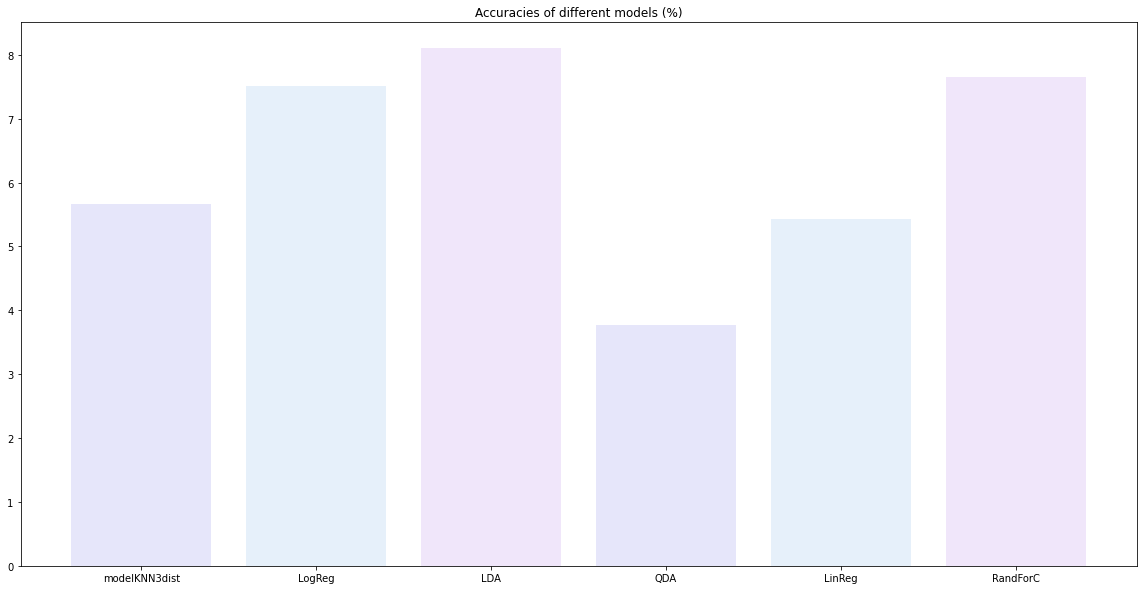

In [157]:
fig, ax = plt.subplots(figsize=(20,10)) 
plt.bar(df_compare.keys(),[df_compare[k][0] for k in df_compare.keys()], color=['#e6e6fa','#e6f0fa','#f0e6fa'])
plt.title("Accuracies of different models (%)")
plt.show()
fig.savefig("acc_models.png")

<a name="diff_year">

### Average absolute difference between predicted year and real year


> Example : 
* `predictions = [2000,1980]` while `reality = [2002,1976]` 
* implies `avg_abs_diff = ((2002 - 2000) + (1980 - 1976)) / 2`
* then `avg_abs_diff = 3 years`
 >> The lower the better

> Here, Linear Regression seems to be the best model, and 3-NN, Logistic Regression, LDA and Random Forest are not so bad.
>> QDA's value is too high : this model is not good enough.


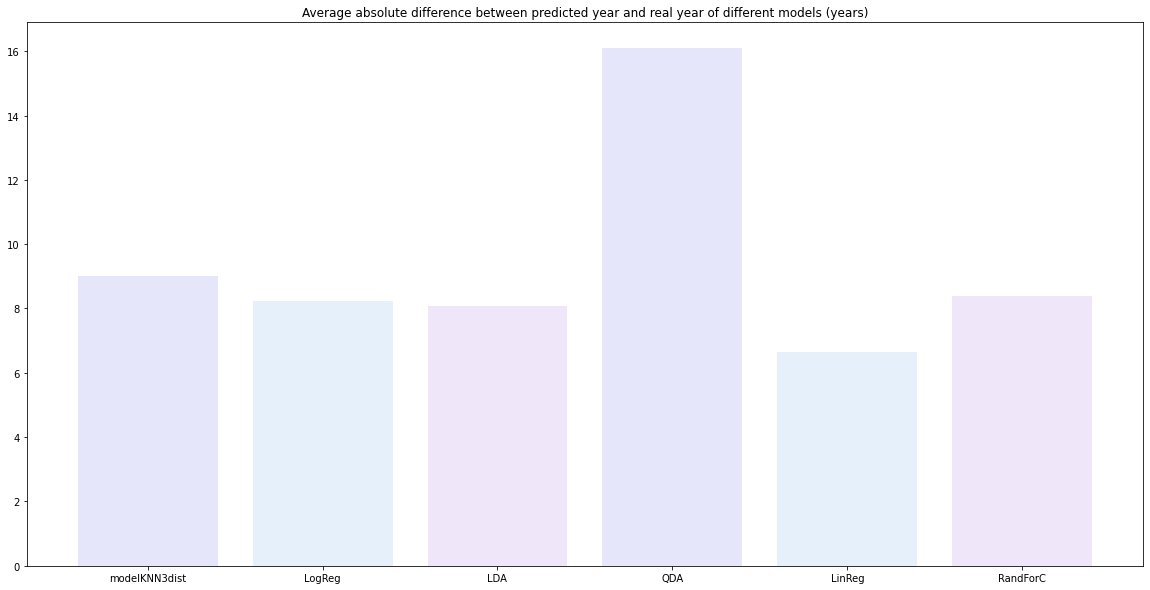

In [155]:
fig, ax = plt.subplots(figsize=(20,10)) 
plt.bar(df_compare.keys(),[df_compare[k][2] for k in df_compare.keys()], color=['#e6e6fa','#e6f0fa','#f0e6fa'])
plt.title("Average absolute difference between predicted year and real year of different models (years)")
plt.show()
fig.savefig("avg_abs_diff_years_models.png")

<a name="diff_nb">

### Average difference between the number of predictions and the number of real year label for each year 

> Example :
* For `year = 1970`, 500 songs (`nb_predicted = 500`) were predicted, while in reality, only 375 songs (`nb_real = 375`) were expected in the test set.
* implies `diff_nb = nb_real - nb_predicted = -125`
* We can say that 1970 is over-predicted
* Then we do the average of diff_nb for all years and we compare each model
>> The lower the better

> Here, 3-NN is obviously the best model. We can conclude that it is not sensible to umbalanced data, contrary to the others, which always over_predict 2000's years.

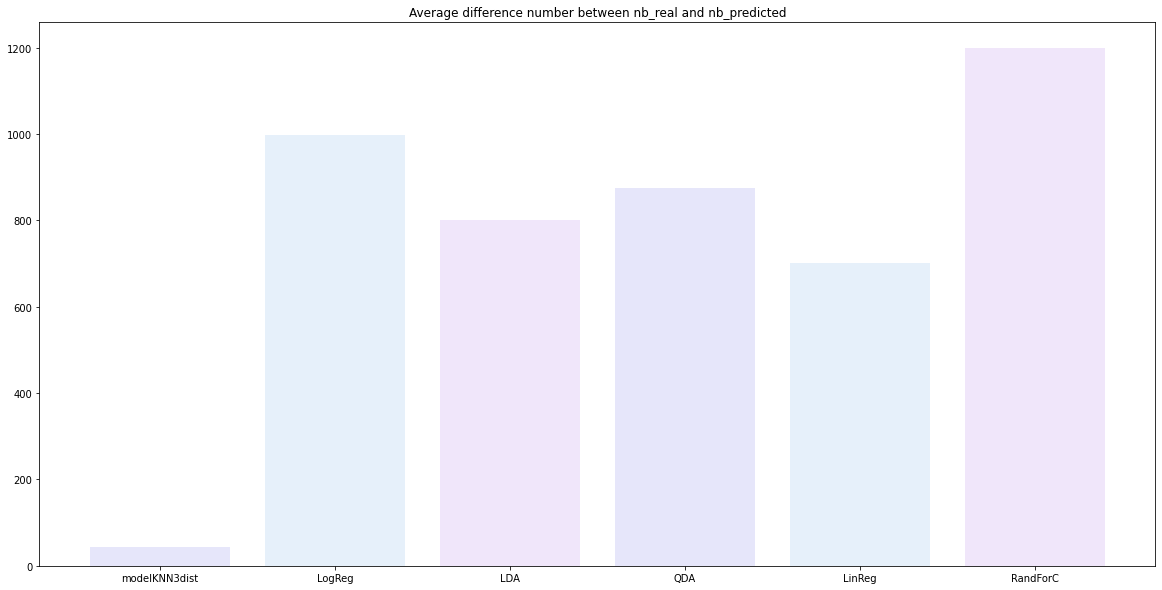

In [156]:
fig, ax = plt.subplots(figsize=(20,10)) 
plt.bar(df_compare.keys(),[np.mean([abs(el) for el in df_compare[k][1].values[0]]) for k in df_compare.keys()], color=['#e6e6fa','#e6f0fa','#f0e6fa'])
plt.title("Average difference number between nb_real and nb_predicted")
plt.show()
fig.savefig("avg_diff_nb_models.png")

<a name="conclusion">

### Conclusion

> The best model, regarding all the metrics I used, seems to be 3-NN.

In [158]:
# Saving our model to use it in our API

pickle_out = open("modelKNN3dist_final.pkl", mode = "wb") 
pickle.dump(modelKNN3dist, pickle_out) 
pickle_out.close()